# Image Processing (Part 1: Preliminaries)

## Objectives

- Plot the RGB histogram of your chosen photo. Plot also the 99th percentile for each channel.
- Visualize the image in HSV (Hue, Saturation, Value) and YUV (Luma, U, V) color space
- Visualize the 2D fourier transform of the grayscale image (BOTH amplitude and phase information)
- Reconstruct the orginal image by retaining only the original phase, also for the case retaining only the original amplitude.


### **Comparison of Color Spaces: RGB vs. HSV vs. YUV**

| **Color Space** | **Description** | **Components** | **Pros** | **Cons** | **Best Used For** |
|---------------|---------------|--------------|---------|---------|--------------|
| **RGB (Red-Green-Blue)** | The standard additive color model where colors are created by mixing red, green, and blue light. | **R** (Red), **G** (Green), **B** (Blue) | - Directly corresponds to display technology (monitors, screens).<br>- Simple and intuitive for image storage and processing. | - Not perceptually uniform (human vision is more sensitive to brightness than color changes).<br>- Difficult to adjust brightness and contrast independently. | - Display and rendering of images on screens.<br>- Basic image processing (e.g., filtering, transformations). |
| **HSV (Hue-Saturation-Value)** | A cylindrical representation of color, separating chromatic information (hue) from intensity (value). | **H** (Hue), **S** (Saturation), **V** (Value) | - More intuitive for human perception (hue-based color changes).<br>- Easier to manipulate brightness and color separately. | - Computationally more complex than RGB.<br>- Less commonly used in direct hardware display. | - Color-based segmentation and detection.<br>- Image editing and artistic transformations. |
| **YUV (Luminance-Chrominance)** | Designed for analog television and video compression, separating brightness (Y) from color (U and V). | **Y** (Luminance), **U** (Blue chrominance), **V** (Red chrominance) | - Efficient for compression and broadcast (used in JPEG, MPEG, and TV signals).<br>- Matches human perception (more sensitive to brightness). | - Not intuitive for direct image editing.<br>- Requires conversion when working with display technologies. | - Video compression and broadcasting.<br>- Image compression (JPEG, MPEG). |


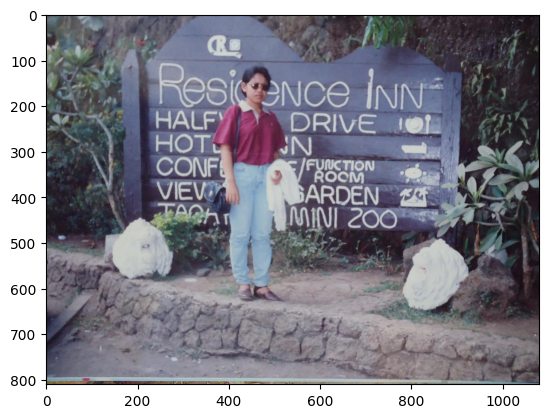

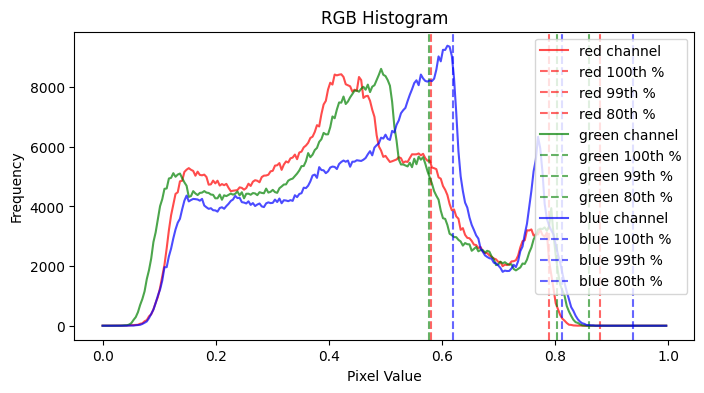

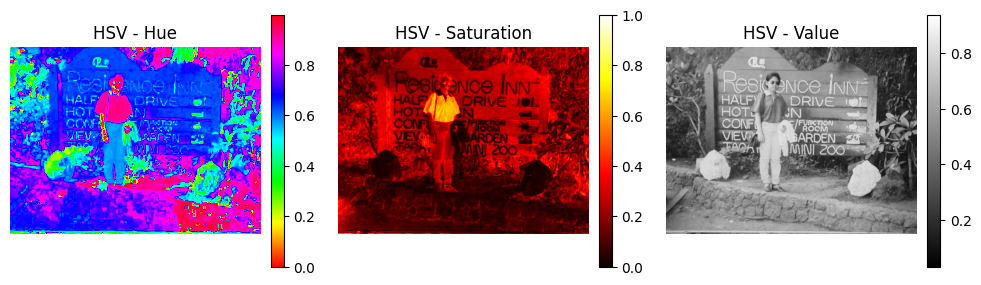

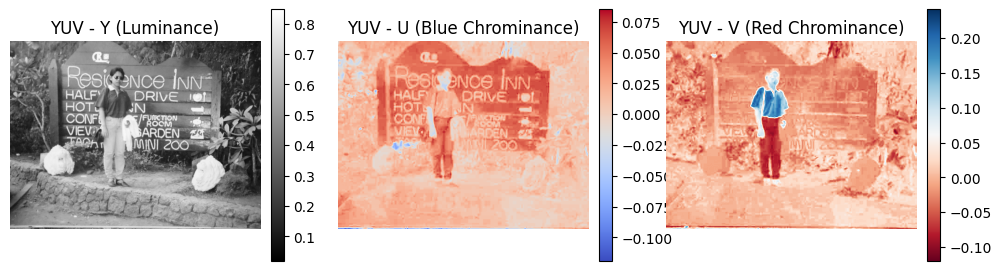

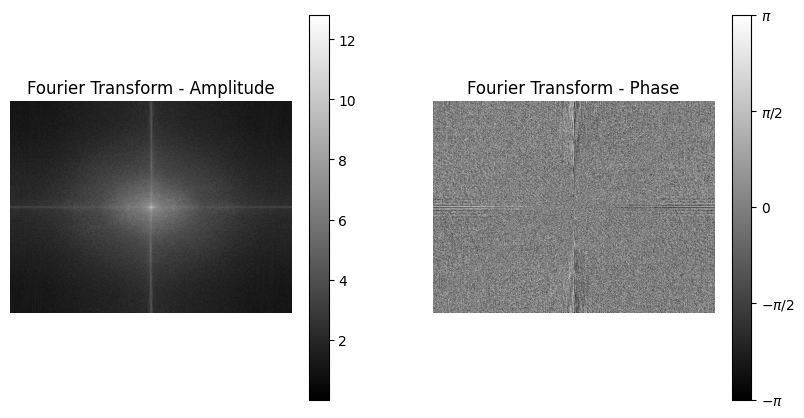

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float
from skimage.color import rgb2gray
from numpy.fft import fft2, fftshift

# Load image
image = img_as_float(io.imread("mama.jpg"))
plt.imshow(image)

# Function to compute and plot RGB histogram with percentile markers
def plot_rgb_histogram(img, title, percentiles=[99]):
    colors = ('red', 'green', 'blue')
    plt.figure(figsize=(8, 4))

    for i, color in enumerate(colors):
        # Compute histogram
        hist, bins = np.histogram(image[:, :, i], bins = 256, range = (0, 1))
        
        plt.plot(bins[:-1], hist, color=color, alpha=0.7, label=f"{color} channel")

        #Compute and plot percentiles
        for p in percentiles:
            p_value = np.percentile(image[:,:,i], p)  # compute percentiles
            plt.axvline(x = p_value, color = color, linestyle = 'dashed', alpha = 0.6, label=f"{color} {p}th %")

    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Call the histogram function
plot_rgb_histogram(image, "RGB Histogram", percentiles=[100, 99, 80])

# Convert to HSV and YUV
image_hsv = color.convert_colorspace(image, "RGB", "HSV")  # Convert using color
image_yuv = color.convert_colorspace(image, "RGB", "YUV")  # Convert using color

# Function to visualize color channels
def plot_channels(img, color_space, titles):
    plt.figure(figsize=(12, 4))
    cmap_hsv = ['hsv', 'hot', 'gray']
    cmap_yuv = ['gray', 'coolwarm', 'RdBu']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        if color_space == 'HSV':
            im = plt.imshow(img[:,:,i], cmap=cmap_hsv[i])  # Fill in image slice
        if color_space == 'YUV':
            im = plt.imshow(img[:,:,i], cmap=cmap_yuv[i])  # Fill in image slice
        plt.title(f"{color_space} - {titles[i]}")
        plt.axis('off')
        plt.colorbar(im, fraction=0.046, pad=0.04)

    plt.show()

# Visualize HSV and YUV channels
plot_channels(image_hsv, "HSV", ["Hue", "Saturation", "Value"])
plot_channels(image_yuv, "YUV", ["Y (Luminance)", "U (Blue Chrominance)", "V (Red Chrominance)"])

# Convert to grayscale and compute 2D Fourier Transform
gray_image = rgb2gray(image)  # Convert image to gray
fft_result = fft2(gray_image)  # Compute fft
fft_shifted = fftshift(fft_result)
# # Compute amplitude and phase
amplitude = np.abs(fft_shifted)  # Compute amplitude
phase = np.angle(fft_shifted)  # Compute phase

# Plot amplitude and phase spectrum
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.log1p(amplitude), cmap='gray')  # amplitude in log-scale for emphasis
plt.colorbar()
plt.title("Fourier Transform - Amplitude")
plt.axis('off')

plt.subplot(1, 2, 2)
im = plt.imshow(phase, cmap='gray', vmin=-np.pi, vmax=np.pi)  # Fill in phase
cbar = plt.colorbar(im, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.ax.set_yticklabels([r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$'])
plt.title("Fourier Transform - Phase")
plt.axis('off')

plt.show()

(-0.5, 1079.5, 809.5, -0.5)

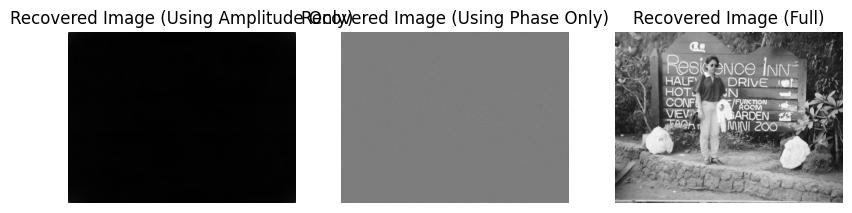

In [2]:
# Reconstruction
from numpy.fft import ifft2, ifftshift

# Use a constant amplitude
amplitude2 = np.ones_like(phase)
# Use a constant phase
phase2=np.ones_like(amplitude)

# Reconstruct the Fourier domain representation
fft_reconstructed1 = amplitude2*np.exp(1j*phase) # reconstruct with original phase only. Use the equation Ae^(i\phi).
fft_reconstructed2 = amplitude*np.exp(1j*phase2) # reconstruct with original amplitude only. Use the equation Ae^(i\phi).

fft_full = amplitude*np.exp(1j*phase)

# Perform inverse Fourier transform
ifft_shifted1 = ifftshift(fft_reconstructed1)
ifft_shifted_full = ifftshift(fft_full)
recovered_image1 = np.real(ifft2(ifft_shifted1))

ifft_shifted2 = ifftshift(fft_reconstructed2)
recovered_image2 = np.real(ifft2(ifft_shifted2))

recovered_full = np.real(ifft2(ifft_shifted_full))
# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(recovered_image2, cmap='gray')
plt.title("Recovered Image (Using Amplitude Only)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(recovered_image1, cmap='gray')
plt.title("Recovered Image (Using Phase Only)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(recovered_full, cmap='gray')
plt.title("Recovered Image (Full)")
plt.axis("off")

# Image Processing (Part 2: White Balancing and Contrast Stretching)

## Objectives

- Calculate various statistics for each channel of your image (mean, std, minimum, median, p_80, p_90, p_99, maximum)
- Perform the White Patch Algorithm. Find the percentile that yields the best result.
- Perform the Gray World Algorithm
- Ground Truth Algorithms. Define a patch in the image you know is white. Find the best patch that yields the best result.
- Perform Contrast Stretching. Find the parameters that yields the best result.
- Discuss the performance of each algorithm, and determine the best one for your chosen image.

### Refer to this [source.](https://python.plainenglish.io/introduction-to-image-processing-with-python-bb39c83366a4)

## 1. **Color Overcast Calculation**  
For each color channel \( $C$ \) (Red, Green, Blue), the statistical measures are computed:  

- **Mean:**  
  $$
  \mu_C = \frac{1}{N} \sum_{i=1}^{N} C_i
  $$
- **Standard Deviation:**  
  $$
  \sigma_C = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (C_i - \mu_C)^2}
  $$

## 2. **White Patch Algorithm**  
This method normalizes an image based on the highest intensity value at a given percentile \( $P$ \):  
  $$
  I' = \frac{I}{P} \cdot 255
  $$
where \( $I$ \) is the original image intensity and \( $P$ \) is the selected percentile value.

## 3. **Gray World Algorithm**  
This method assumes that the average color of an image should be gray:  
  $$
  I'_C = I_C \cdot \frac{\mu}{\mu_C}
  $$
where:  
- \( $I_C$ \) is the original pixel intensity for channel \( $C$ \)  
- \( $\mu_C$ \) is the mean intensity of channel \( $C$ \)  
- \( $\mu$ \) is the overall mean intensity of the entire image  

## 4. **Ground Truth Algorithm**  
The correction factor is obtained from a reference patch we know is white:  

- **Mean-based correction:**  
  $$
  I' = I \cdot \frac{\mu_{\text{patch}}}{\mu_{\text{image}}}
  $$
- **Max-based correction:**  
  $$
  I' = \frac{I}{\max(\text{patch})}
  $$

## 5. **Contrast Stretching**  
Enhances contrast by rescaling pixel intensities based on lower and upper percentiles:  
  $$
  I' = \frac{(I - I_{\min})}{(I_{\max} - I_{\min})} \cdot 255
  $$
where:  
- \( $I_{\min}$ \) and \( $I_{\max}$ \) are the pixel intensities at the given percentiles.
- Apply this to each color channel.


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.io import imread, imshow
from matplotlib.patches import Rectangle

#Refer to the source for the sample codes for the white patch, gray world, and ground truth algorithms

def calc_color_overcast(image):
    # Calculate color overcast for each channel
    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    blue_channel = image[:, :, 2]

    # Create a dataframe to store the results
    channel_stats = pd.DataFrame(columns=['Mean', 'Std', 'Min', 'Median', 'P_80', 'P_90', 'P_99', 'Max'])

    # Compute and store the statistics for each color channel
    for channel, name in zip([red_channel, green_channel, blue_channel], ['Red', 'Green', 'Blue']):
        mean = np.mean(channel)
        std = np.std(channel)
        minimum = np.min(channel)
        median = np.median(channel)
        p_80 = np.percentile(channel, 80)
        p_90 = np.percentile(channel, 90)
        p_99 = np.percentile(channel, 99)
        maximum = np.max(channel)

        channel_stats.loc[name] = [mean, std, minimum, median, p_80, p_90, p_99, maximum]

    return channel_stats
def white_patch(image, percentile=100):
    """
    Returns a plot comparison of original and corrected/white balanced image 
    using the White Patch algorithm.

    Parameters
    ----------
    image : numpy array
            Image to process using white patch algorithm
    percentile : integer, optional
                  Percentile value to consider as channel maximum
    """
    white_patch_image = img_as_ubyte(
        (image * 1.0 / np.percentile(image, 
                                     percentile, 
                                     axis=(0, 1))).clip(0, 1))
    # Plot the comparison between the original and white patch corrected images
#     fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    fig, ax = plt.subplots(figsize=(10, 5))
#     ax[0].imshow(image)
#     ax[0].set_title('Original Image')
#     ax[0].axis('off')

    ax.imshow(white_patch_image, cmap='gray')
    ax.set_title(f'White Patch Corrected Image p = {p}')
    ax.axis('off')

    plt.show()

def gray_world(image):
    """
    Returns a plot comparison of original and corrected/white balanced image 
    using the Gray World algorithm.

    Parameters
    ----------
    image : numpy array
            Image to process using gray world algorithm
    """
    # Apply the Gray World algorithm
#     image_grayworld = ((image * (image.mean() / image.mean(axis=(0, 1)))).clip(0, 255).astype(int))
    image = img_as_ubyte(image) if image.dtype != np.uint8 else image
    image_grayworld = np.zeros_like(image, dtype=np.uint8)
    for i in range(3):
        image_grayworld[:, :, i] = (image[:,:,i] * (np.mean(image) / np.mean(image[:,:,i]))).clip(0, 255).astype(int)
    # Exclude alpha or opacity channel (transparency)
    if image.shape[2] == 4:
        image_grayworld[:, :, 3] = 255

    # Plot the comparison between the original and gray world corrected images
#     fig, ax = plt.subplots(1, 2, figsize=(14, 10))
    fig, ax = plt.subplots(figsize=(10, 5))
#     ax[0].imshow(image)
#     ax[0].set_title('Original Image')
#     ax[0].axis('off')

    ax.imshow(image_grayworld)
    ax.set_title('Gray World Corrected Image')
    ax.axis('off')

    plt.show()

def ground_truth(image, img_patch, mode='mean', position = None):
    """
    Returns a plot comparison of original and corrected/white balanced image 
    using the Ground Truth algorithm.

    Parameters
    ----------
    image : numpy array
            Image to process using ground truth algorithm
    img_patch : numpy array
                Reference image patch
    mode : string, optional
           Calculation mode, either 'mean' or 'max'
    """
    if mode == 'mean':
        image_gt = ((image * (img_patch.mean() / image.mean(axis=(0, 1)))).clip(0, 255).astype(int))
    if mode == 'max':
        image_gt = ((image * 1.0 / img_patch.max(axis=(0, 1))).clip(0, 1))

    # Exclude alpha or opacity channel (transparency)
    if image.shape[2] == 4:
        image_gt[:, :, 3] = 255

    # Plot the comparison between the original and ground truth corrected images
#     fig, ax = plt.subplots(1, 2, figsize=(14, 10))
    fig, ax = plt.subplots(figsize=(10, 5))
#     ax[0].imshow(image)
#     ax[0].set_title('Original Image')
#     ax[0].axis('off')

    ax.imshow(image_gt)
    ax.set_title(f'Ground Truth Corrected Image {position}')
    ax.axis('off')

    plt.show()

# Contrast stretching

def contrast_stretching(image, lower_percentile=2, upper_percentile=98):
    """
    Performs contrast stretching on an image using specified percentile limits.

    Parameters
    ----------
    image : numpy array
        Input image to be contrast-stretched.
    lower_percentile : float, optional
        Lower percentile value for intensity rescaling (default is 2).
    upper_percentile : float, optional
        Upper percentile value for intensity rescaling (default is 98).

    Returns
    -------
    stretched_image : numpy array
        The contrast-enhanced image.
    """
    # Convert image to float for safe computation
    image = img_as_ubyte(image) if image.dtype != np.uint8 else image
    stretched_image = np.zeros_like(image, dtype=np.uint8)
    
    # Apply contrast stretching per channel
    for i in range(3):
        # Compute the lower and upper bounds for the given percentiles
        min_val = np.percentile(image[:,:,i], lower_percentile) # compute the lower percentile for each channel
        max_val = np.percentile(image[:,:,i], upper_percentile) # compute the higher percentile for each channel
        print(min_val, max_val)
        # Perform contrast stretching using linear transformation
        stretched_image[:,:,i] = np.clip((image[:,:,i] - min_val)/(max_val - min_val)*255, 0, 255).astype(np.uint8)

    return stretched_image

def plot_contrast_stretching(image, lower_percentile=2, upper_percentile=98):
    """
    Returns a plot comparison of the original and contrast-stretched image.

    Parameters
    ----------
    image : numpy array
            Image to process using contrast stretching.
    lower_percentile : float, optional
            Lower percentile for contrast stretching (default is 2).
    upper_percentile : float, optional
            Upper percentile for contrast stretching (default is 98).
    """
    # Apply contrast stretching
    stretched_image = contrast_stretching(image, lower_percentile, upper_percentile)

    # Plot the original and contrast-stretched images
#     fig, ax = plt.subplots(1, 2, figsize=(14, 10))
    fig, ax = plt.subplots(figsize = (10,5))

#     ax[0].imshow(image)
#     ax[0].set_title('Original Image')
#     ax[0].axis('off')

    ax.imshow(stretched_image)
    ax.set_title(f'Contrast Stretched Image: {lower_percentile}-{upper_percentile} Percentiles')
    ax.axis('off')

    plt.show()


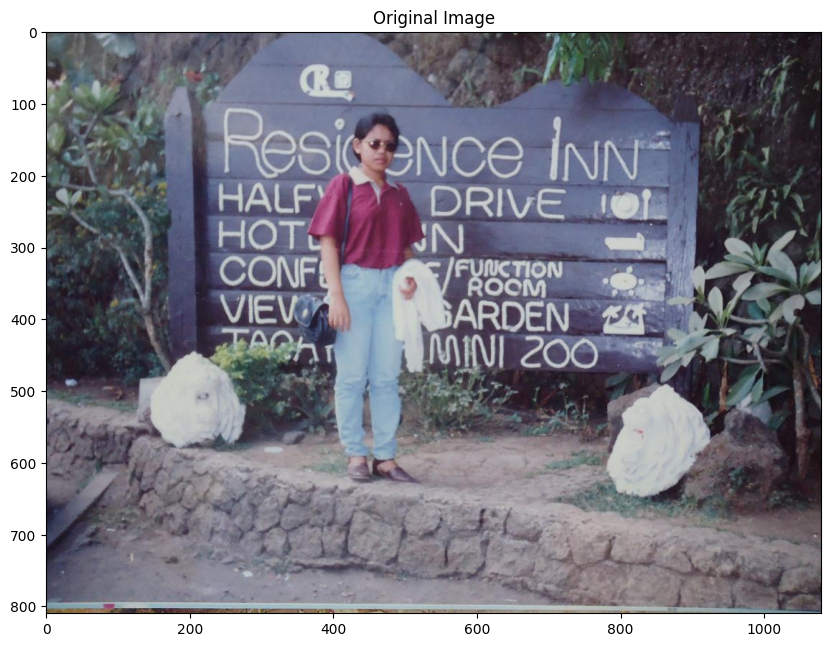

In [4]:
image = io.imread('mama.jpg')

# Visualize your original image here
plt.figure(figsize=(10,10))
plt.title('Original Image')
plt.imshow(image)
plt.show()

In [5]:
# Check for the image channel statistics
calc_color_overcast(image)

Mean        Std  Min  Median   P_80   P_90   P_99    Max
Red    108.063033  44.898521  0.0   108.0  148.0  170.0  201.0  224.0
Green  107.196948  47.521354  3.0   109.0  147.0  173.0  205.0  219.0
Blue   119.256077  47.339227  0.0   124.0  158.0  185.0  207.0  239.0

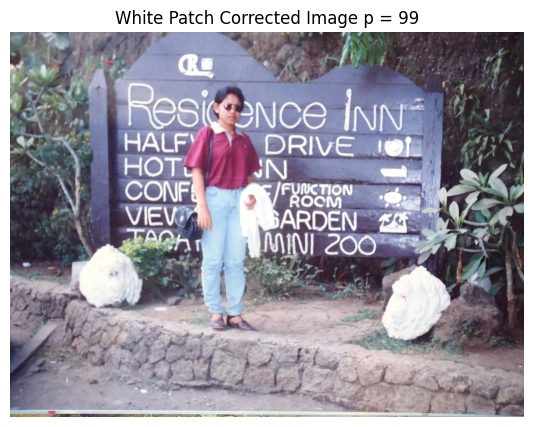

In [6]:
# Call the function to implement white patch algorithm. Find the best percentile.
p = 99
white_patch(image, p)

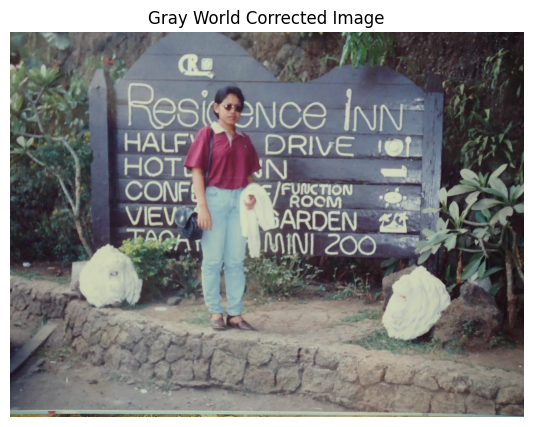

In [7]:
# Call the function to apply the Gray World algorithm
gray_world(image)

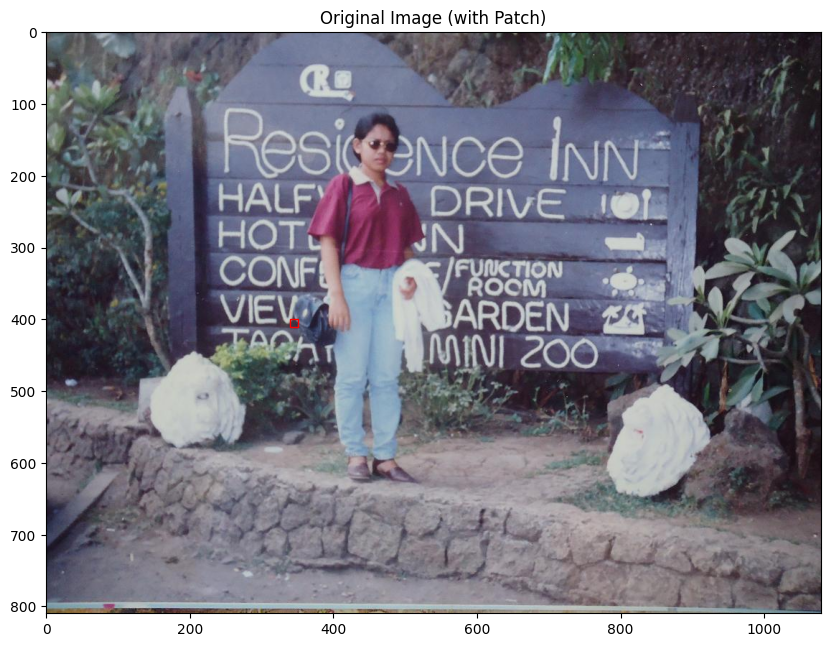

In [8]:
# Call the function to apply the Ground Truth algorithm
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Original Image (with Patch)')
ax.imshow(image)
posx = 340
posy = 400
r = 10
ax.add_patch(Rectangle((posx, posy), r, r, edgecolor='r', facecolor='none'))

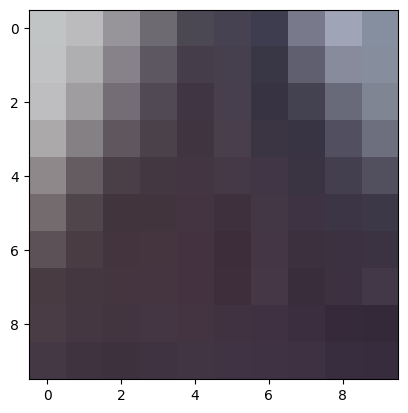

In [9]:
img_patch = image[posy:(posy+r), posx:(posx+r)]
plt.imshow(img_patch)

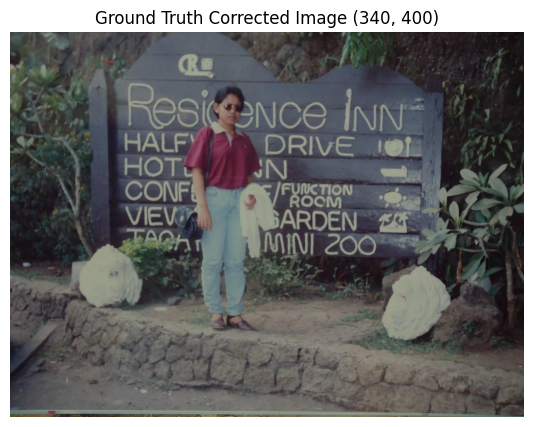

In [10]:
# posx = 400
# posy = 570
posx = 340
posy = 400
img_patch = image[posy:(posy+r), posx:(posx+r)]
#         plt.imshow(img_patch)
ground_truth(image, img_patch, mode='mean', position = (posx, posy))

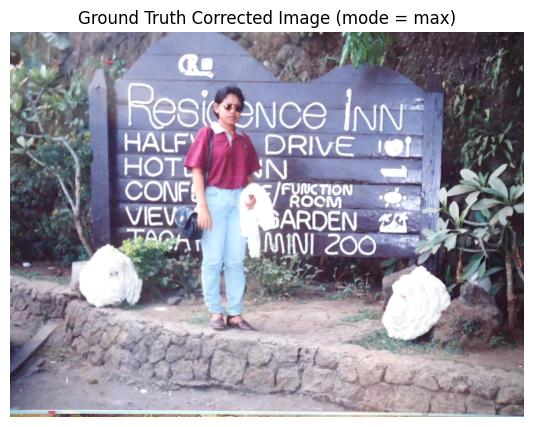

In [11]:
posx = 340
posy = 400
img_patch = image[posy:(posy+r), posx:(posx+r)]
ground_truth(image, img_patch, mode='max', position = "(mode = max)")

31.0 198.0
25.0 202.0
32.0 204.0


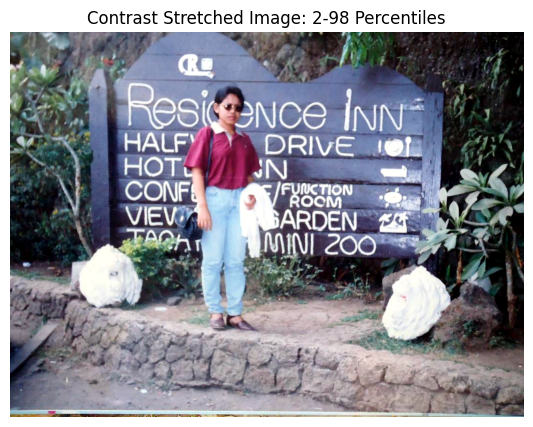

In [12]:
# Call the function to apply the contrst stretching algorithm
# p_min = [2, 3, 4, 5, 6, 7, 8]
# p_max = [98, 99]
# for pm in p_min:
#     for px in p_max:
plot_contrast_stretching(image)